# Kernelized Linear Classification Project

### Importing Data

In [134]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from math import exp
# For hyperparameter tuning
from skopt.space import Real, Integer
from skopt import gp_minimize
from skopt.utils import use_named_args

In [390]:
dataset_pd = pd.read_csv('your_dataset.csv')
dataset = dataset_pd.to_numpy()
dataset_pd

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,y
0,1.205492,5.823226,98.837539,-1.075852,0.999205,0.911543,3.623558,-1.720267,-0.346191,-54.708330,-1
1,1.391530,3.611581,98.857197,-5.020318,0.677165,0.999492,3.413112,4.253865,2.041603,-54.317291,1
2,1.692571,-0.887019,100.901276,-0.595548,0.177550,-0.915495,4.320264,0.907834,3.126815,-56.397484,-1
3,4.289320,1.416843,100.784735,-2.897154,-0.066972,-0.786173,2.093003,1.336237,2.183829,-56.197728,1
4,0.542420,-1.010095,100.015580,-3.070705,0.088324,-0.242669,0.767942,-0.284683,-2.104145,-55.794045,1
...,...,...,...,...,...,...,...,...,...,...,...
9995,0.481134,-0.572225,99.274788,-0.868047,-0.663229,0.572447,5.163238,1.765743,0.720265,-54.952233,-1
9996,0.047373,0.990198,100.444834,-0.707179,0.912113,-0.510397,1.128577,0.116130,-2.559018,-56.008656,-1
9997,1.741933,0.036304,100.524071,-0.113742,-0.761337,-0.728295,-1.334732,-1.312760,-0.442573,-56.170876,-1
9998,2.574986,0.041442,98.983735,-1.937883,0.983004,0.798133,5.847342,0.904038,-1.695064,-54.820699,1


In [3]:
class1 = np.count_nonzero(dataset == 1)
class2 = np.count_nonzero(dataset == -1)
print(f'Distribution of the binary class in the dataset:\n 1: {class1} , -1: {class2}')

Distribution of the binary class in the dataset:
 1: 4992 , -1: 5008


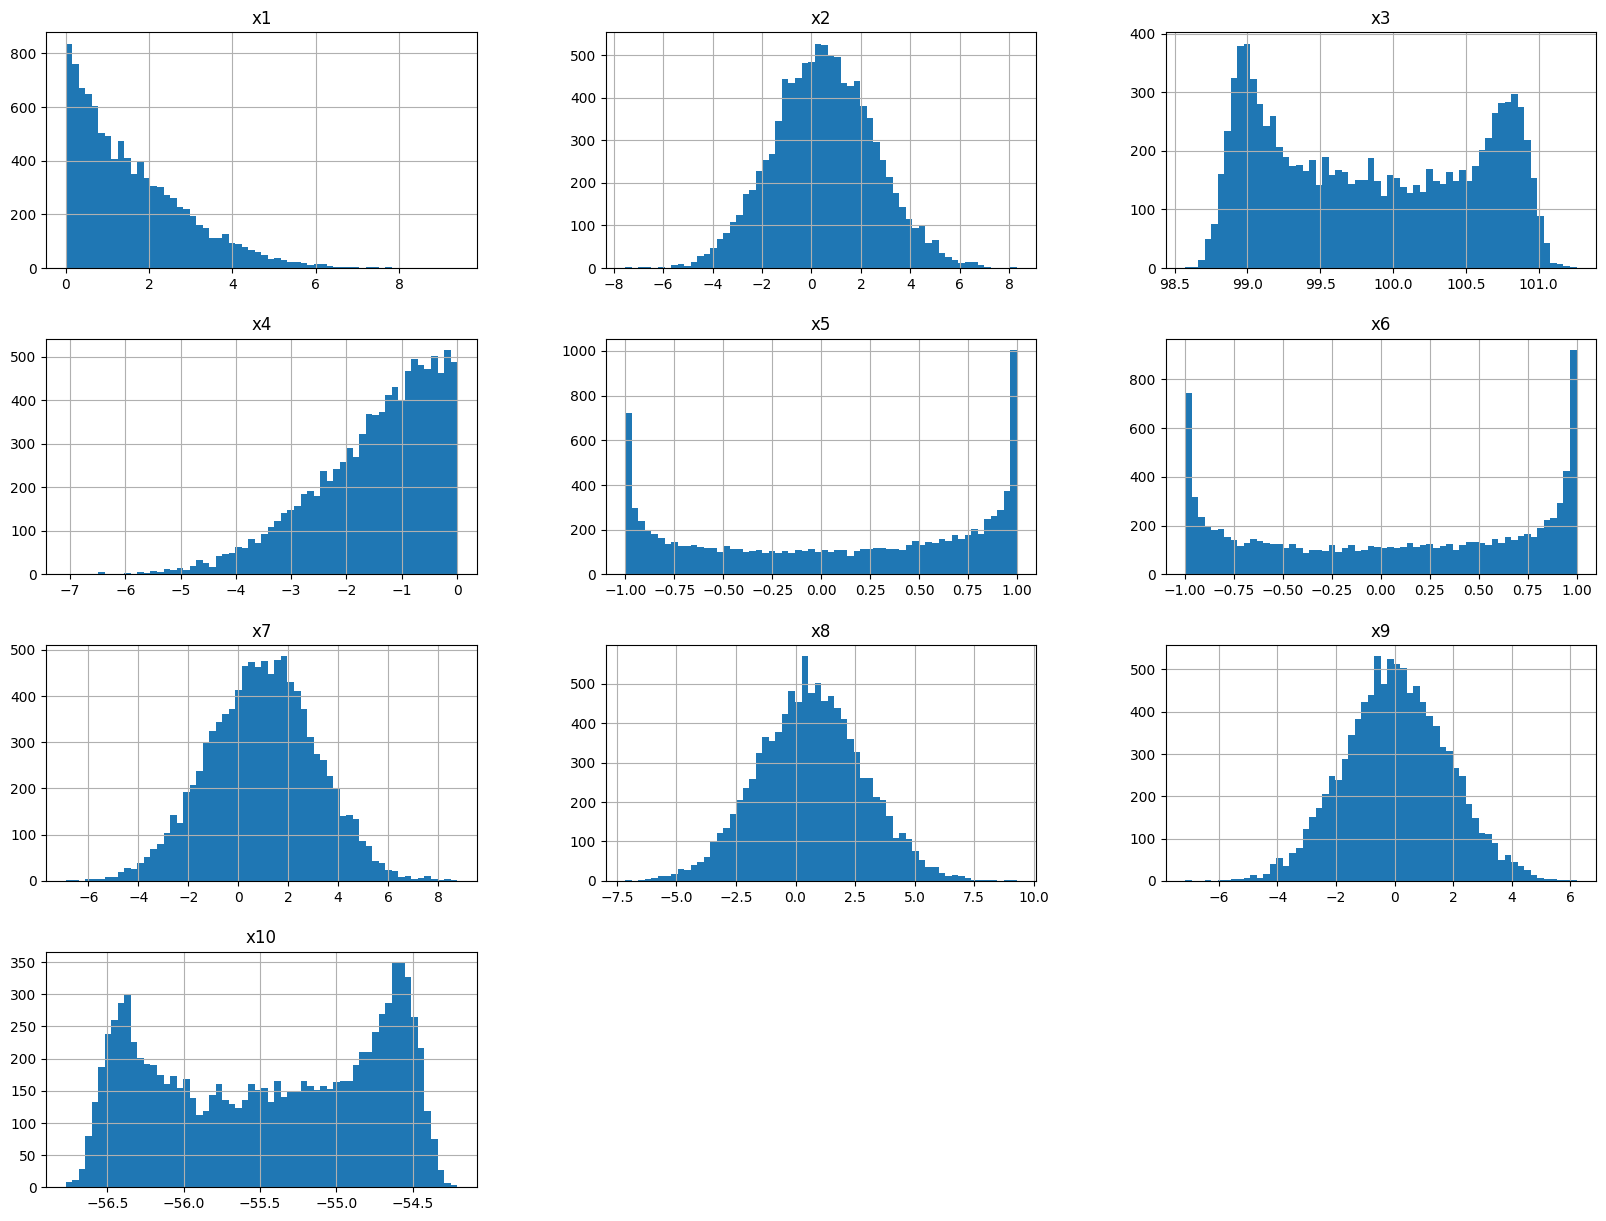

In [4]:
# Histogram of Features
dataset_pd.iloc[:, :-1].hist(bins=60, figsize=(20, 15))
plt.show()

### Preprocessing

In [5]:
# Seperating data points and labels
X = np.array([x[:-1] for x in dataset])
y = np.array([int(x[-1]) for x in dataset])

print(f'X: {X.shape[0]} samples and {X.shape[1]} features, y: {y.shape[0]} labels')

X: 10000 samples and 10 features, y: 10000 labels


In [139]:
# Split data points and label to training and test categories
def data_split(X, y, train_size=0.85):
    x_train = X[:int(train_size * len(X))]
    x_test = X[int(train_size * len(X)):]
    y_train = y[:int(train_size * len(y))]
    y_test = y[int(train_size * len(y)):]

    return x_train, x_test, y_train, y_test

# split data set to train and test samples
x_train, x_test, y_train, y_test = data_split(X, y, train_size=0.85)

x_train.shape, x_test.shape, y_train.shape, y_test.shape 

((8500, 10), (1500, 10), (8500,), (1500,))

### Scaling Methods

In [7]:
def z_score(set_train, set_test):
    mean = np.mean(set_train, axis=0)
    std = np.std(set_train, axis=0)
    z_train = (set_train - mean) / std
    z_test = (set_test - mean) / std # scale test set with mean and standard deviation from training set
    return z_train, z_test

def min_max(set_train, set_test):
    minimum = np.min(set_train, axis=0)
    maximum = np.max(set_train, axis=0)
    return (set_train - minimum) / (maximum - minimum), (set_test - minimum) / (maximum - minimum) 
    

In [8]:
# Scale data
x_train_scaled, x_test_scaled = z_score(x_train, x_test)

### Testing

#### Accuracy

In [9]:
def accuracy(y_test, y_pred):
    T = 0
    for i in range(len(y_test)):
        if y_test[i] == y_pred[i]:
            T += 1

    return 100 * T / len(y_test)

#### Cross validation (K-fold)

In [131]:
def k_fold(data, k=5):
    fold_size = len(data) // 5
    indx = np.arange(len(data))
    folds= []

    for i in range(k):
        test_indx = indx[i * fold_size : (i+1) * fold_size] 
        train_indx = np.concatenate([indx[ : i * fold_size], indx[(i+1) * fold_size : ]])
        folds.append([train_indx, test_indx])

    return folds

# Make indicies for k-fold (Training set and validation set)
k = 5
fold_indx = k_fold(x_train, k)
fold_indx

[[array([1700, 1701, 1702, ..., 8497, 8498, 8499]),
  array([   0,    1,    2, ..., 1697, 1698, 1699])],
 [array([   0,    1,    2, ..., 8497, 8498, 8499]),
  array([1700, 1701, 1702, ..., 3397, 3398, 3399])],
 [array([   0,    1,    2, ..., 8497, 8498, 8499]),
  array([3400, 3401, 3402, ..., 5097, 5098, 5099])],
 [array([   0,    1,    2, ..., 8497, 8498, 8499]),
  array([5100, 5101, 5102, ..., 6797, 6798, 6799])],
 [array([   0,    1,    2, ..., 6797, 6798, 6799]),
  array([6800, 6801, 6802, ..., 8497, 8498, 8499])]]

## Learning Algorithms

### Perceptron Algorithm

In [317]:
class Perceptron():
    def __init__(self, learning_rate, n_iters):
        self.lr = learning_rate
        self.n_iters = n_iters

    def fit(self, X, y):
        n_samples, n_features = X.shape
        
        # Initialize weights
        self.w = np.zeros(n_features)
        
        # Training
        for _ in range(self.n_iters):
            for i, x in enumerate(X):
                y_predict = self.step(x @ self.w)

                # Updating
                if y_predict != y[i]:
                    self.w += self.lr * y[i] * x

        return self.w

    def step(self, x):
        return np.where(x > 0, 1, -1)

    def predict(self, x):
        y_predict = self.step(np.dot(x, self.w))
        return np.where(y_predict > 0, 1, -1)
    

In [323]:
# Bayesian Optimization for Hyperparameter Tuning Perceptron

# Parameters to Tune
search_space = [
    Real(1e-2, 1e-1, name='learning_rate'),
    Integer(600, 1100, name='n_iters'),
]

# Objective Function
@use_named_args(search_space)
def objective_function(**params):
    learning_rate, n_iters = params['learning_rate'], params['n_iters']
    # Initialize Model
    p = Perceptron(learning_rate, n_iters)

    accuracies = []
    # k-fold
    for train, validate in fold_indx:
        x_train_fold, y_train_fold = x_train[train], y[train]
        x_validate_fold, y_validate_fold = x_train[validate], y[validate]
        # Scaling data
        x_train_scaled_fold, x_validate_scaled_fold = z_score(x_train_fold, x_validate_fold)

        # Train Model
        p.fit(x_train_scaled_fold, y_train_fold)
        # Predict 
        y_pred = p.predict(x_validate_scaled_fold)
        # Accuracy of Model
        accuracies.append(accuracy(y_validate_fold, y_pred))

    # Average of k-fold Accuracies
    score = sum(accuracies) / k
    return -score

result = gp_minimize(objective_function, search_space, n_calls=10, random_state=42)

print(f'Best parameters:\n learning_rate={result.x[0]}, Iterations={result.x[1]}\n Accuracy: {-result.fun}')

Best parameters:
 learning_rate=0.015077042112439026, Iterations=961
 Accuracy: 64.02352941176471


In [324]:
# Initializing Model with tuned parameters
p = Perceptron(learning_rate=result.x[0], n_iters=result.x[1])

# Scaling Data
x_train_scaled, x_test_scaled = z_score(x_train, x_test)

# Train Model
w_perceptron = p.fit(x_train_scaled, y_train)

# Predict
y_pred = p.predict(x_test_scaled)

# Accuracy
accuracy(y_test, y_pred)

62.266666666666666

### Support Vector Machines (SVMs) using the Pegasos Algorithm 

In [318]:
class SVMPegasos():
    def __init__(self, lambda_param=0.01, n_iters=1000):
        self.lambda_param = lambda_param
        self.n_iters = n_iters

    def fit(self, X, y):
        n_samples, n_features = X.shape

        # Initialize weights
        self.w = np.zeros(n_features)
        self.weight = np.zeros(n_features)

        # Training
        for t in range(1, self.n_iters + 1):
            eta = 1 / (self.lambda_param * t)
            i = random.randint(0, n_samples - 1)

            # Updating
            if y[i] * X[i] @ self.w < 1:
                self.w = (1 - 1/t) * self.w + (eta * y[i] * X[i])
                self.weight += self.w
            else:
                self.w = (1 - 1/t) * self.w
                self.weight += self.w

        return self.weight / self.n_iters

    def predict(self, x):
        weight = self.weight / self.n_iters
        return np.sign(x @ weight )
            

In [255]:
# Bayesian Optimization for Hyperparameter Tuning SVM with Pegasos

# Parameters to Tune
search_space = [
    Real(1e-2, 5e-1, name='lambda_param'),
    Integer(10000, 100000, name='n_iters'),
]

# Objective Function
@use_named_args(search_space)
def objective_function(**params):
    lambda_param, n_iters = params['lambda_param'], params['n_iters']
    # Initialize Model
    svmp = SVMPegasos(lambda_param, n_iters)

    accuracies = []
    # k-fold
    for train, validate in fold_indx:
        x_train_fold, y_train_fold = x_train[train], y[train]
        x_validate_fold, y_validate_fold = x_train[validate], y[validate]
        # Scaling data
        x_train_scaled_fold, x_validate_scaled_fold = z_score(x_train_fold, x_validate_fold)

        # Train Model
        svmp.fit(x_train_scaled_fold, y_train_fold)
        # Predict 
        y_pred = svmp.predict(x_validate_scaled_fold)
        # Accuracy of Model
        accuracies.append(accuracy(y_validate_fold, y_pred))

    # Average of k-fold Accuracies
    score = sum(accuracies) / k
    return -score

result = gp_minimize(objective_function, search_space, n_calls=50, random_state=42)

print(f'Best parameters:\n lambda_param={result.x[0]}, Iterations={result.x[1]}\n Accuracy: {-result.fun}')

Best parameters:
 lambda_param=0.011497632413220356, Iterations=99806
 Accuracy: 73.01176470588236


In [361]:
# Initializing Model with tuned parameters
svmp = SVMPegasos(lambda_param=result.x[0], n_iters=result.x[1])

# Scaling Data
x_train_scaled, x_test_scaled = z_score(x_train, x_test)

# Train Model
w_svm = svmp.fit(x_train_scaled, y_train)

# Predict
y_pred = svmp.predict(x_test_scaled)

# Accuracy
accuracy(y_test, y_pred)

71.06666666666666

### Regularized Logistic Classification

In [319]:
class PegasosLogistic():
    def __init__(self, lambda_param=0.01, n_iters=1000):
        self.lambda_param = lambda_param
        self.n_iters = n_iters

    def fit(self, X, y):
        n_samples, n_features = X.shape

        # Initialize weights
        self.w = np.zeros(n_features)

        # Training
        for t in range(1, self.n_iters+1):
            eta = 1 / (self.lambda_param * t)
            i = random.randint(0, n_samples-1)
            z = self.sigmoid(X[i] @ self.w)

            # Updating 
            if y[i] != z:
                self.w = (1 - 1/t) * self.w - (eta * (z - y[i]) * X[i])

        return self.w

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def predict(self, x):
        z = self.sigmoid(x @ self.w)
        return np.where(z >= 0.5, 1, -1)
    

In [257]:
# Bayesian Optimization for Hyperparameter Tuning Pegasos with Logistic loss

# Parameters to Tune
search_space = [
    Real(1e-2, 5e-1, name='lambda_param'),
    Integer(10000, 100000, name='n_iters'),
]

# Objective Function
@use_named_args(search_space)
def objective_function(**params):
    lambda_param, n_iters = params['lambda_param'], params['n_iters']
    # Initialize Model
    pl = PegasosLogistic(lambda_param, n_iters)

    accuracies = []
    # k-fold
    for train, validate in fold_indx:
        x_train_fold, y_train_fold = x_train[train], y[train]
        x_validate_fold, y_validate_fold = x_train[validate], y[validate]
        # Scaling data
        x_train_scaled_fold, x_validate_scaled_fold = z_score(x_train_fold, x_validate_fold)

        # Train Model
        pl.fit(x_train_scaled_fold, y_train_fold)
        # Predict 
        y_pred = pl.predict(x_validate_scaled_fold)
        # Accuracy of Model
        accuracies.append(accuracy(y_validate_fold, y_pred))

    # Average of k-fold Accuracies
    score = sum(accuracies) / k
    return -score

result = gp_minimize(objective_function, search_space, n_calls=10, random_state=42)

print(f'Best parameters:\n learning_rate={result.x[0]}, Iterations={result.x[1]}\n Accuracy: {-result.fun}')

Best parameters:
 learning_rate=0.08000474078175099, Iterations=68580
 Accuracy: 72.51764705882354


In [365]:
# Initializing Model with tuned parameters
pl = PegasosLogistic(result.x[0], result.x[1])

# Scaling Data
x_train_scaled, x_test_scaled = z_score(x_train, x_test)

# Train model
w_pl = pl.fit(x_train_scaled, y_train)

# Predict
y_pred = pl.predict(x_test_scaled)

# Accuracy
accuracy(y_test, y_pred)

71.26666666666667

## Polynomial Feature Expansion of Algorithms

In [24]:
def polynomial_features_d2(X):
    n_samples, n_features = X.shape
    poly_features = []

    # Adding original features
    poly_features.append(X)

    # Adding the squared of the original features
    for i in range(n_features):
        poly_features.append(X[:, i:i+1] ** 2)

    # Adding all the combinations of multiplications between features
    for i in range(n_features):
        for j in range(i+1, n_features):
            poly_features.append(X[:, i:i+1] * X[:, j:j+1])
        
    return np.hstack(poly_features) 


In [167]:
# Expanding the original dataset features
poly_X = polynomial_features_d2(X)
print('Dimension of the dataset with polynomial feature expansion of degree 2:\n', poly_X.shape)

# Splitting train and test sets
x_train_poly, x_test_poly, y_train, y_test = data_split(poly_X, y, train_size=0.85)
print('Dimesions of training and test sets after feature expansion of degree 2:')
x_train_poly.shape, x_test_poly.shape, y_train.shape, y_test.shape 

Dimension of the dataset with polynomial feature expansion of degree 2:
 (10000, 65)
Dimesions of training and test sets after feature expansion of degree 2:


((8500, 65), (1500, 65), (8500,), (1500,))

In [168]:
# Scale data points with expanded features
x_train_poly_scaled, x_test_poly_scaled = z_score(x_train_poly, x_test_poly)

### Perceptron (Polynomial Features)

In [260]:
# Tuning Hyper-parameters

# Parameters to Tune
search_space = [
    Real(1e-2, 1e-1, name='learning_rate'),
    Integer(200, 1000, name='n_iters'),
]

# Objective Function
@use_named_args(search_space)
def objective_function(**params):
    learning_rate, n_iters = params['learning_rate'], params['n_iters']
    # Initialize Model
    pp = Perceptron(learning_rate, n_iters)

    accuracies = []
    # k-fold
    for train, validate in fold_indx:
        x_train_fold, y_train_fold = x_train_poly[train], y[train]
        x_validate_fold, y_validate_fold = x_train_poly[validate], y[validate]
        # Scaling data
        x_train_scaled_fold, x_validate_scaled_fold = z_score(x_train_fold, x_validate_fold)

        # Train Model
        pp.fit(x_train_scaled_fold, y_train_fold)
        # Predict 
        y_pred = pp.predict(x_validate_scaled_fold)
        # Accuracy of Model
        accuracies.append(accuracy(y_validate_fold, y_pred))

    # Average of k-fold Accuracies
    score = sum(accuracies) / k
    return -score

result = gp_minimize(objective_function, search_space, n_calls=10, random_state=42)

print(f'Best parameters:\n learning_rate={result.x[0]}, Iterations={result.x[1]}\n Accuracy: {-result.fun}')

Best parameters:
 learning_rate=0.022858013612974674, Iterations=721
 Accuracy: 88.56470588235294


In [326]:
# Initializing Model with tuned parameters
p_poly = Perceptron(learning_rate=result.x[0], n_iters=result.x[1])

# Train Model
w_perceptron_poly = p_poly.fit(x_train_poly_scaled, y_train)

# Predict 
y_pred = p_poly.predict(x_test_poly_scaled)

# Accuracy
accuracy(y_test, y_pred)

89.46666666666667

### SVM Pegasos (Polynomial Features)

In [262]:
# Tuning Hyper-parameters

# Parameters to Tune
search_space = [
    Real(1e-2, 5e-1, name='lambda_param'),
    Integer(10000, 100000, name='n_iters'),
]

# Objective Function
@use_named_args(search_space)
def objective_function(**params):
    lambda_param, n_iters = params['lambda_param'], params['n_iters']
    # Initialize Model
    svmpp = SVMPegasos(lambda_param, n_iters)

    accuracies = []
    # k-fold
    for train, validate in fold_indx:
        x_train_fold, y_train_fold = x_train_poly[train], y[train]
        x_validate_fold, y_validate_fold = x_train_poly[validate], y[validate]
        # Scaling data
        x_train_scaled_fold, x_validate_scaled_fold = z_score(x_train_fold, x_validate_fold)

        # Train Model
        svmpp.fit(x_train_scaled_fold, y_train_fold)
        # Predict 
        y_pred = svmpp.predict(x_validate_scaled_fold)
        # Accuracy of Model
        accuracies.append(accuracy(y_validate_fold, y_pred))

    # Average of k-fold Accuracies
    score = sum(accuracies) / k
    return -score

result = gp_minimize(objective_function, search_space, n_calls=50, random_state=42)

print(f'Best parameters:\n lambda_param={result.x[0]}, Iterations={result.x[1]}\nAccuracy: {-result.fun}')

C:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [0.01, 100000] before, using random point [0.01969264183405751, 44722]
  warnings.warn(
C:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [0.01, 100000] before, using random point [0.33320505948497403, 82736]
  warnings.warn(
C:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [0.01, 100000] before, using random point [0.17815191283079532, 36363]
  warnings.warn(
C:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [0.01, 100000] before, using random point [0.19294026034392645, 17305]
  warnings.warn(
C:\U

Best parameters:
 lambda_param=0.01, Iterations=100000
Accuracy: 90.68235294117648


In [374]:
# Initializing Model with tuned parameters
# svm_poly = SVMPegasos(lambda_param=result.x[0], n_iters=result.x[1])
svm_poly = SVMPegasos(lambda_param=0.01, n_iters=100000)

# Train Model
w_svm_poly = svm_poly.fit(x_train_poly_scaled, y_train)

# Predict
y_pred = svm_poly.predict(x_test_poly_scaled)

# Accuracy
accuracy(y_test, y_pred)

90.33333333333333

### Regularized Logistic (Polynomial Features)

In [264]:
# Tuning Hyper-parameters

# Parameters to Tune
search_space = [
    Real(1e-2, 5e-1, name='lambda_param'),
    Integer(10000, 100000, name='n_iters'),
]

# Objective Function
@use_named_args(search_space)
def objective_function(**params):
    lambda_param, n_iters = params['lambda_param'], params['n_iters']
    # Initialize Model
    pl = PegasosLogistic(lambda_param, n_iters)

    accuracies = []
    # k-fold
    for train, validate in fold_indx:
        x_train_fold, y_train_fold = x_train_poly[train], y[train]
        x_validate_fold, y_validate_fold = x_train_poly[validate], y[validate]
        # Scaling data
        x_train_scaled_fold, x_validate_scaled_fold = z_score(x_train_fold, x_validate_fold)

        # Train Model
        pl.fit(x_train_scaled_fold, y_train_fold)
        # Predict 
        y_pred = pl.predict(x_validate_scaled_fold)
        # Accuracy of Model
        accuracies.append(accuracy(y_validate_fold, y_pred))

    # Average of k-fold Accuracies
    score = sum(accuracies) / k
    return -score


# Bayesian Optimization for Hyperparameter Tuning
result = gp_minimize(objective_function, search_space, n_calls=10, random_state=42)
print(f'Best parameters:\n learning_rate={result.x[0]}, Iterations={result.x[1]}\nAccuracy:\n {-result.fun}')

C:\Users\Asus\AppData\Local\Temp\ipykernel_26952\180497208.py:23: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


Best parameters:
 learning_rate=0.08000474078175099, Iterations=68580
Accuracy:
 79.67058823529412


In [375]:
# Initializing Model with tuned parameters
pl_poly = PegasosLogistic(lambda_param=0.08000474078175099, n_iters=68580)

# Train Model
w_pl_poly = pl_poly.fit(x_train_poly_scaled, y_train)

# Predict
y_pred = pl_poly.predict(x_test_poly_scaled)

# Accuracy
accuracy(y_test, y_pred)

79.86666666666666

### Weight Comparison

In [348]:
avg_per_poly = sum(w_perceptron_poly[:10]) / 10
avg_per = sum(w_perceptron) / 10
print(f'Perceptron linear feature weight comparison:\n Average weight: {avg_per}\n Average linear weight after expansion:{avg_per_poly}\n Absolute difference:{abs(avg_per_poly - avg_per)}')

Perceptron linear feature weight comparison:
 Average weight: 0.0035163061566456737
 Average linear weight after expansion:-0.0010178638232066993
 Absolute difference:0.004534169979852373


In [380]:
avg_svm_poly = sum(w_svm_poly[:10]) / 10
avg_svm = sum(w_svm) / 10
print(f'SVM linear feature weight comparison:\n Average weight: {avg_svm}\n Average linear weight after expansion:{avg_svm_poly}\n Absolute difference:{abs(avg_svm_poly - avg_svm)}')

SVM linear feature weight comparison:
 Average weight: 0.19967926930755936
 Average linear weight after expansion:0.04139284751392648
 Absolute difference:0.1582864217936329


In [391]:
avg_pl_poly = sum(w_pl_poly[:10]) / 10
avg_pl = sum(w_pl) / 10
print(f'Pegasos Logistic linear feature weight comparison:\n Average weight: {avg_pl}\n Average linear weight after expansion:{avg_pl_poly}\n Absolute difference:{abs(avg_pl_poly - avg_pl)}')

Pegasos Logistic linear feature weight comparison:
 Average weight: 2.042220136312469
 Average linear weight after expansion:0.2651583202279282
 Absolute difference:1.7770618160845406


## Algorithms using Kernel Methods

### Kernelized Perceptron

In [385]:
class PerceptronKernelized():

    def polynomial_kernel(self, x1, x2, d=2, c=1):
        result = (x1 @ x2 + c) ** d
        return result

    def guassian_kernel(self, x1, x2, sigma=1):
        result = np.exp((-np.linalg.norm(x1 - x2) ** 2) / (2 * sigma ** 2))
        return result
    
    def fit_predict_polynomial(self, X, y, x_test, d):
        n_samples, n_features = X.shape
        self.S = []
        
        # Training
        for i in range(n_samples):
            y_pred = np.sign(sum(y[j] * self.polynomial_kernel(X[j], X[i], d) for j in self.S))
            if y_pred != y[i]:
                self.S.append(i)
                
        # Predict
        predict = []
        for x in x_test:
            ans = np.sign(sum(y[j] * self.polynomial_kernel(X[j], x, d) for j in self.S))
            predict.append(ans)

        return np.array(predict)


    def fit_predict_guassian(self, X, y, x_test, sigma):
        n_samples, n_features = X.shape
        self.S = []
        
        # Training
        for t in range(1, self.n_iters+1):
            
            for i in range(n_samples):
                y_pred = np.sign(sum(y[j] * self.guassian_kernel(X[j], X[i], sigma) for j in self.S))
                if y_pred != y[i]:
                    self.S.append(i)
                
        # Predict
        predict = []
        for x in x_test:
            ans = np.sign(sum(y[j] * self.guassian_kernel(X[j], x, sigma) for j in self.S))
            predict.append(ans)

        return np.array(predict)


In [388]:
# Tuning Hyper-parameters

# Parameters to Tune
search_space = [
    Integer(2, 4, name='degree')
]

@use_named_args(search_space)
def objective_function(**params):
    degree = params['degree']
    # Initialize Model
    pk = PerceptronKernelized()

    accuracies = []
    # k-fold
    for train, validate in fold_indx:
        x_train_fold, y_train_fold = x_train[train], y[train]
        x_validate_fold, y_validate_fold = x_train[validate], y[validate]
        # Scaling data
        x_train_scaled_fold, x_validate_scaled_fold = z_score(x_train_fold, x_validate_fold)

        # Train Model and Predict
        y_pred_polynomial = pk.fit_predict_polynomial(x_train_scaled_fold, y_train_fold, x_validate_scaled_fold, degree)
        # Accuracy
        accuracies.append(accuracy(y_validate_fold, y_pred_polynomial))

    # Average of k-fold Accuracies
    score = sum(accuracies) / k
    return -score

result = gp_minimize(objective_function, search_space, n_calls=10, random_state=42)

print(f'Best parameters:\n Degree={result.x[0]}, \n Accuracy: {-result.fun}')

Best parameters:
 Degree=4, 
 Accuracy: 91.43529411764705


In [389]:
# Initializing Model with tuned parameters
pp_model = PerceptronKernelized()

# Train Model and Predict
y_pred_poly = pp_model.fit_predict_polynomial(x_train_scaled, y_train, x_test_scaled, result.x[0])

# Accuracy
accuracy(y_test, y_pred_guassian)

88.0

In [299]:
# Tuning Hyper-parameters

# Parameters to Tune
search_space = [
    Real(1e-2, 1, name='sigma'),
]

@use_named_args(search_space)
def objective_function(**params):
    sigma = params['sigma']
    # Initialize Model
    pk = PerceptronKernelized()

    accuracies = []
    # k-fold
    for train, validate in fold_indx:
        x_train_fold, y_train_fold = x_train[train], y[train]
        x_validate_fold, y_validate_fold = x_train[validate], y[validate]
        # Scaling data
        x_train_scaled_fold, x_validate_scaled_fold = z_score(x_train_fold, x_validate_fold)

        # Train Model and Predict
        y_pred_guassian = pp_model.fit_predict_guassian(x_train_scaled_fold, y_train_fold, x_validate_scaled_fold, sigma)
        # Accuracy
        accuracies.append(accuracy(y_validate_fold, y_pred_guassian))

    # Average of k-fold Accuracies
    score = sum(accuracies) / k
    return -score

result = gp_minimize(objective_function, search_space, n_calls=10, random_state=42)

print(f'Best parameters:\n Sigma={result.x[0]}, \n Accuracy: {-result.fun}')

Best parameters:
 Sigma=0.7985775569916307, 
 Accuracy: 90.0


In [313]:
# Initializing Model with tuned parameters
pp_model = PerceptronKernelized()

# Train Model and Predict
y_pred_poly = pp_model.fit_predict_polynomial(x_train_scaled, y_train, x_test_scaled, result.x[0])

# Accuracy
accuracy(y_test, y_pred_poly)

91.93333333333334

### Kernelized SVM

In [200]:
class SVMKernelized():
    def __init__(self, n_iters=1000):
        self.n_iters = n_iters

    def polynomial_kernel(self, x1, x2, d=2, c=1):
        return (x1 @ x2 + c) ** d
    
    def guassian_kernel(self, x1, x2, sigma=1):
        return np.exp((-np.linalg.norm(x1 - x2) ** 2) / (2 * sigma ** 2))

    def fit_predict_polynomial(self, X, y, x_test, d):
        n_samples, n_features = X.shape
        self.S = []

        # Traininig
        for t in range(1, self.n_iters+1):
            i = random.randint(0, n_samples-1)
            pred = np.sign(sum(y[j] * self.polynomial_kernel(X[j], X[i], d) for j in self.S))
            if y[i] != pred:
                self.S.append(i)

        # Predict
        predict = []        
        for x in x_test:
            ans = np.sign(sum(y[j] * self.polynomial_kernel(X[j], x, d) for j in self.S))
            predict.append(ans)

        return predict


    def fit_predict_guassian(self, X, y, x_test, sigma):
        n_samples, n_features = X.shape
        self.S = []

        # Training
        for t in range(1, self.n_iters+1):
            i = random.randint(0, n_samples-1)
            pred = np.sign(sum(y[j] * self.guassian_kernel(X[j], X[i], sigma) for j in self.S))
            if y[i] != pred:
                self.S.append(i)

        # Predict
        predict = []        
        for x in x_test:
            ans = np.sign(sum(y[j] * self.guassian_kernel(X[j], x, sigma) for j in self.S))
            predict.append(ans)

        return predict       

In [274]:
# Tuning Hyper-parameters

# Parameters to Tune
search_space = [
    Integer(2, 4, name='degree'),
    Integer(3000, 6000, name='n_iters'),
]

@use_named_args(search_space)
def objective_function(**params):
    degree, n_iters = params['degree'], params['n_iters']

    # Initialize Model
    svmk = SVMKernelized(n_iters)

    accuracies = []
    # k-fold
    for train, validate in fold_indx:
        x_train_fold, y_train_fold = x_train[train], y[train]
        x_validate_fold, y_validate_fold = x_train[validate], y[validate]
        # Scaling data
        x_train_scaled_fold, x_validate_scaled_fold = z_score(x_train_fold, x_validate_fold)

        # Train Model and Predict
        y_pred_polynomial = svmk.fit_predict_polynomial(x_train_scaled_fold, y_train_fold, x_validate_scaled_fold, degree)
        # Accuracy
        accuracies.append(accuracy(y_validate_fold, y_pred_polynomial))

    # Average of k-fold Accuracies
    score = sum(accuracies) / k
    return -score

result = gp_minimize(objective_function, search_space, n_calls=25, random_state=42)

print(f'Best parameters:\n Degree={result.x[0]}, Iterations={result.x[1]}\n Accuracy: {-result.fun}')

C:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [2, 6000] before, using random point [2, 3560]
  warnings.warn(
C:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [2, 6000] before, using random point [4, 4030]
  warnings.warn(
C:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [2, 6000] before, using random point [3, 4120]
  warnings.warn(
C:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [2, 6000] before, using random point [3, 5834]
  warnings.warn(
C:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\skopt\optimizer\optimizer.py

Best parameters:
 Degree=2, Iterations=6000
 Accuracy: 90.90588235294118


In [275]:
# Initializing Model with tuned parameters
sk_model = SVMKernelized(n_iters=result.x[1])

x_train_scaled, x_test_scaled = z_score(x_train, x_test)

# Train Model and Predict 
y_pred_polynomial = sk_model.fit_predict_polynomial(x_train_scaled, y_train, x_test_scaled, result.x[0])

# Accuracy
accuracy(y_test, y_pred_polynomial)

90.86666666666666

In [281]:
# Tuning Hyper-parameters

# Parameters to Tune
search_space = [
    Real(1e-2, 1, name='sigma'),
    Integer(4000, 6000, name='n_iters'),
]

@use_named_args(search_space)
def objective_function(**params):
    sigma, n_iters = params['sigma'], params['n_iters']
    
    # Initialize Model
    svmk = SVMKernelized(n_iters)

    accuracies = []
    # k-fold
    for train, validate in fold_indx:
        x_train_fold, y_train_fold = x_train[train], y[train]
        x_validate_fold, y_validate_fold = x_train[validate], y[validate]
        # Scaling data
        x_train_scaled_fold, x_validate_scaled_fold = z_score(x_train_fold, x_validate_fold)

        # Train Model and Predict
        y_pred_guassian = sk_model.fit_predict_guassian(x_train_scaled_fold, y_train_fold, x_validate_scaled_fold, sigma)
        # Accuracy
        accuracies.append(accuracy(y_validate_fold, y_pred_guassian))

    # Average of k-fold Accuracies
    score = sum(accuracies) / k
    return -score

result = gp_minimize(objective_function, search_space, n_calls=20, random_state=42)

print(f'Best parameters:\n sigma={result.x[0]}, Iterations={result.x[1]}\n Accuracy: {-result.fun}')

Best parameters:
 sigma=0.9905423544993747, Iterations=5340
 Accuracy: 89.4


In [283]:
# Initializing Model with tuned parameters
sk_model = SVMKernelized(n_iters=result.x[1])

# Train Model and Predict 
y_pred_guassian = sk_model.fit_predict_guassian(x_train_scaled, y_train, x_test_scaled, result.x[0])

# Accuracy
accuracy(y_test, y_pred_guassian)

88.0